In [1]:
# ==========================================================================================
#                                 PREAMBLE (module load)
# ==========================================================================================
# Import of the Python Standard Library modules required for the analysis
import glob, os, subprocess, sys			# To act on the operative system
import json									# To read and write JSON files
import matplotlib as mpl					# For plotting
import matplotlib.pyplot as plt				# For plotting
import numpy as np							# For numerical analysis
import warnings								# To deactivate the warnings
import time									# For script timing
import logging								# For logging purposes
import datetime								# For timestamp printing
import copy									# To copy objects

import yaml                                 # For editing yaml files (necessary for fermipy)
from fermipy.gtanalysis import GTAnalysis   # To run fermipy utilities
from astropy.io import fits                 # To open fits files
from gammapy.maps import WcsNDMap           # To plot maps

# Import of personal functions from custom modules
sys.path.append("../../Functions")
from MyFunctions import fitter_linear, truehisto1D, histoplotter1D
from AstroFunctions import angdist

# Set the warnings of a few functions
np.seterr(divide='ignore', invalid='ignore')	# To avoid 0/0 errors
#mpl.rcParams['backend'] = 'agg'					# Non-interactive backend for plotting
warnings.filterwarnings("ignore", category=DeprecationWarning) # To avoid deprecation warnings

# =========================================================================================
#                                      COMMON DEFINITIONS                                      
# =========================================================================================
# Define the dimension for the fonts in the plots, the figures dimensions and so on
textfont = 20			# Fontsize for labels and legends
dimfig = (12,7)			# Figure dimensions (A4-like)
dimfigbig = (16,12)		# Figure dimensions (a bit larger than A4-like)
dimfiglong = (16,25)	# Figure dimensions (a bit larger and much longer than A4-like)
filetype = '.pdf'		# File format to save the pictures
filedpi = 520			# Resolution used when saving pictures in .png/.jpeg
nptsfit = 10000			# Number of points used in plotting the fits

# ==========================================================================================
#                                  STATUS FILE DATA
# ==========================================================================================
# Open the status file
statusfile = '../statusfile.json'
with open(statusfile) as json_file:
	statusdata = json.load(json_file)

# Extract all the relevant variables from the file
datadir = statusdata['datadir']
imgdir = statusdata['imgdir']
tempdir = statusdata['tempdir']
dataSCdir = statusdata['dataSCdir']
dataPHdir = statusdata['dataPHdir']
catalog_file_4FGL = statusdata['catalog_file_4FGL']
catalog_file_3FHL = statusdata['catalog_file_3FHL']
catalog_file_3FHL_reg = statusdata['catalog_file_3FHL_reg']
catalog_file_3FHL_regAssoc = statusdata['catalog_file_3FHL_regAssoc']

# Define the name for the subfolders (in imgdir and tempdir) where we will save
# the temporary images and files
pretempdir = '04_4FHL'
imgdir = os.path.join(imgdir,pretempdir)
tempdir = os.path.join(tempdir,pretempdir)

# Setting of the logging module
logfile = "debug.log"
logging.basicConfig(format='[%(asctime)s] %(message)s',level=logging.INFO,
					handlers=[logging.FileHandler(logfile,mode='w'),
					logging.StreamHandler()])
logging.info("*"*75)
#logging.info(f"Beginning the execution of {__file__}")
logging.info(f"")

[2025-01-22 14:41:33,863] ***************************************************************************
[2025-01-22 14:41:33,865] 


In [2]:
# ==========================================================================================
#                                 INPUT PARSING
# ==========================================================================================
# Define what quadrants to include in the analysis
config = "egal" 
if (config == "all"):
    # Use all quadrants
    quadrantInds = list(range(44))
elif (config == "egal"):
    # Use all quadrants except the gal plane ones
    quadrantInds = list(range(44))
    for num in range(16,27):
        quadrantInds.remove(num)
else:
    # Use a custom rule
    quadrantInds = list(range(6))

numQuadrants = len(quadrantInds)
logging.info(f"Quadrants to look: {quadrantInds}")

[2025-01-22 14:41:33,882] Quadrants to look: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]


In [29]:
# ==========================================================================================
#                             OPTIMAL CONFIGURATION
# ==========================================================================================
# Determine the optimal configuration for pgwave2D
pgwave_simdir = '05_simPgwaveOut'
optfilename = os.path.join(tempdir, pgwave_simdir, 'pgwave2D_bestconfig.npz')
best_scala = np.load(optfilename)['best_scala']
best_otpix = np.load(optfilename)['best_otpix']

# ==========================================================================================
#                               QUADRANT ITERATION
# ==========================================================================================
# Iterate on all the quadrants. For each of them, we will extract the data corresponding
# to the best pgwave2D configuration (flux/counts and positions of all real and localized sources)
simdir = '05_simCMAPs'
all_matchedRealFlux = np.zeros((0,))
all_matchedPgCounts = np.zeros((0,))
all_matchedDistances = np.zeros((0,))
all_matchedPosErr = np.zeros((0,))
all_matchedSNR = np.zeros((0,))
all_matchedKsignif = np.zeros((0,))
all_matchedGLat = np.zeros((0,))
all_matchedGLon = np.zeros((0,))

for j,quadrantInd in enumerate(quadrantInds):
    # ======================================================================================
    #                                 DATA EXTRACTION
    # ======================================================================================
    # Open the file created after the simulation and containing the simulated sources and the 
    # pgwave2D output
    logging.info("*"*50)
    logging.info(f"Looking at quadrant: {quadrantInd}")

    filename_fermipy = os.path.join(tempdir,simdir,f'pgSIM_fermisim_Q{quadrantInd:02d}.npz')
    filename_pgwave = os.path.join(tempdir, pgwave_simdir,f"Q{quadrantInd:02d}", 
                                   f"pgSIM_scala_{best_scala}_otpix_{int(best_otpix)}.npz")

    with np.load(filename_fermipy) as f:
        realSources_blat  = f['all_blat']
        realSources_blong = f['all_blong']
        realSources_flux  = f['allflux']

    with np.load(filename_pgwave) as f:
        pgSources_blat     = f['pg_b']
        pgSources_blong    = f['pg_l']
        pgSources_counts   = f['pg_counts']
        pgSources_pos_err  = f['pg_pos_err']
        pgSources_snr      = f['pg_snr']
        pgSources_k_signif = f['pg_k_signif']

    # ======================================================================================
    #                                 SOURCE MATCHING
    # ======================================================================================
    # Iterate on all the real sources and match them
    mindist_thr = 0.15 # [deg]
    indsRealMatching = []
    indsPgMatching = []
    numRealSources = np.shape(realSources_flux)[0]

    for i in range(numRealSources):
        # Compute the distance from this source to all the pgwave ones and see if the closest
        # is under threshold. If so, we have a match
        thisdist = angdist(realSources_blat[i],realSources_blong[i],pgSources_blat,pgSources_blong,ifdeg=True)
        if np.min(thisdist) <= mindist_thr:
            indsRealMatching.append(i)
            indsPgMatching.append(np.argmin(thisdist))

    # Extract the matched sources fluxes and the other parameters
    matchedRealFlux = realSources_flux[indsRealMatching]
    matchedPgCounts = pgSources_counts[indsPgMatching]
    matchedDistance = angdist(realSources_blat[indsRealMatching],realSources_blong[indsRealMatching],
                              pgSources_blat[indsPgMatching],pgSources_blong[indsPgMatching],ifdeg=True)
    matchedPosErr = pgSources_pos_err[indsPgMatching]
    matchedSNR = pgSources_snr[indsPgMatching]
    matchedKsignif = pgSources_k_signif[indsPgMatching]
    matchedGLat = pgSources_blat[indsPgMatching]
    matchedGLon = pgSources_blong[indsPgMatching]
    

    # Save the outputs of this iteration step
    all_matchedRealFlux = np.hstack((all_matchedRealFlux,matchedRealFlux))
    all_matchedPgCounts = np.hstack((all_matchedPgCounts,matchedPgCounts))
    all_matchedDistances = np.hstack((all_matchedDistances,matchedDistance))
    all_matchedPosErr = np.hstack((all_matchedPosErr,matchedPosErr))
    all_matchedSNR = np.hstack((all_matchedSNR,matchedSNR))
    all_matchedKsignif = np.hstack((all_matchedKsignif,matchedKsignif))
    all_matchedGLat = np.hstack((all_matchedGLat,matchedGLat)) 
    all_matchedGLon = np.hstack((all_matchedGLon,matchedGLon)) 

    logging.info("Quadrant completed!")
    logging.info("")

logging.info("All quadrants done!")
logging.info("*"*50)

[2025-01-22 16:07:26,133] **************************************************
[2025-01-22 16:07:26,136] Looking at quadrant: 0
[2025-01-22 16:07:26,168] Quadrant completed!
[2025-01-22 16:07:26,172] 
[2025-01-22 16:07:26,175] **************************************************
[2025-01-22 16:07:26,178] Looking at quadrant: 1
[2025-01-22 16:07:26,217] Quadrant completed!
[2025-01-22 16:07:26,218] 
[2025-01-22 16:07:26,221] **************************************************
[2025-01-22 16:07:26,224] Looking at quadrant: 2
[2025-01-22 16:07:26,247] Quadrant completed!
[2025-01-22 16:07:26,248] 
[2025-01-22 16:07:26,250] **************************************************
[2025-01-22 16:07:26,252] Looking at quadrant: 3
[2025-01-22 16:07:26,273] Quadrant completed!
[2025-01-22 16:07:26,275] 
[2025-01-22 16:07:26,276] **************************************************
[2025-01-22 16:07:26,279] Looking at quadrant: 4
[2025-01-22 16:07:26,295] Quadrant completed!
[2025-01-22 16:07:26,296] 
[2025

# To be changed in code

In [4]:
# ==========================================================================================
#                                EVENT TAGGING
# ==========================================================================================
# Define a procedure to locate outliars in the dataset
thrK = 25
thrCounts = 3000
logging.info(f"Tagging outliars as: (pgwave2D K-significance >= {thrK} && pgwave2D counts <= {thrCounts})")
cond_outliars = (all_matchedKsignif <= thrK) & (all_matchedPgCounts >= thrCounts)
cond_true = (cond_outliars == False)

logging.info(f"Tagging as outliars: {cond_outliars.sum()} / {cond_true.shape[0]} sources")


[2025-01-22 14:41:34,687] Tagging outliars as: (pgwave2D K-significance >= 25 && pgwave2D counts <= 3000)
[2025-01-22 14:41:34,691] Tagging as outliars: 12 / 1251 sources


In [5]:
# ==========================================================================================
#                                 CALIBRATION
# ==========================================================================================
# Compute the errors
all_matchedPgErrs = np.sqrt(all_matchedPgCounts)

# Computing the correlation between the real fluxes and the pgwave counts
r = np.corrcoef(all_matchedRealFlux[cond_true],all_matchedPgCounts[cond_true])[0,1]
logging.info(f"Correlation between real flux and pgwave counts: {r:.3f}")
logging.info(f"")

# Fit the flux vs counts relationship with a straight line
result, xth, yth = fitter_linear(all_matchedRealFlux[cond_true],all_matchedPgCounts[cond_true],
                                 all_matchedPgErrs[cond_true])

# Format the output
m,q = result.params['m'].value,result.params['q'].value
m_err, q_err = result.params['m'].stderr,result.params['q'].stderr
logging.info("Fitting: pgwave2D counts = m*flux + q")
logging.info("Fit parameters:")
logging.info(f"\t m = {m:.2e} +/- {m_err:.2e} counts / (photons / cm2 s)")
logging.info(f"\t q = {q:.2f} +/- {q_err:.2f} counts")
logging.info(f"")

[2025-01-22 14:41:34,713] Correlation between real flux and pgwave counts: 0.821
[2025-01-22 14:41:34,715] 
[2025-01-22 14:41:34,741] Fitting: pgwave2D counts = m*flux + q
[2025-01-22 14:41:34,742] Fit parameters:
[2025-01-22 14:41:34,743] 	 m = 8.08e+11 +/- 3.93e+09 counts / (photons / cm2 s)
[2025-01-22 14:41:34,745] 	 q = 150.47 +/- 0.47 counts
[2025-01-22 14:41:34,746] 


[2025-01-22 14:43:03,505] Plotting the histos1D (flux and pgwave2D counts distibutions)...
/tmp/ipykernel_1773/1879360652.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(),color=color1)
/tmp/ipykernel_1773/1879360652.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(),color=color2)


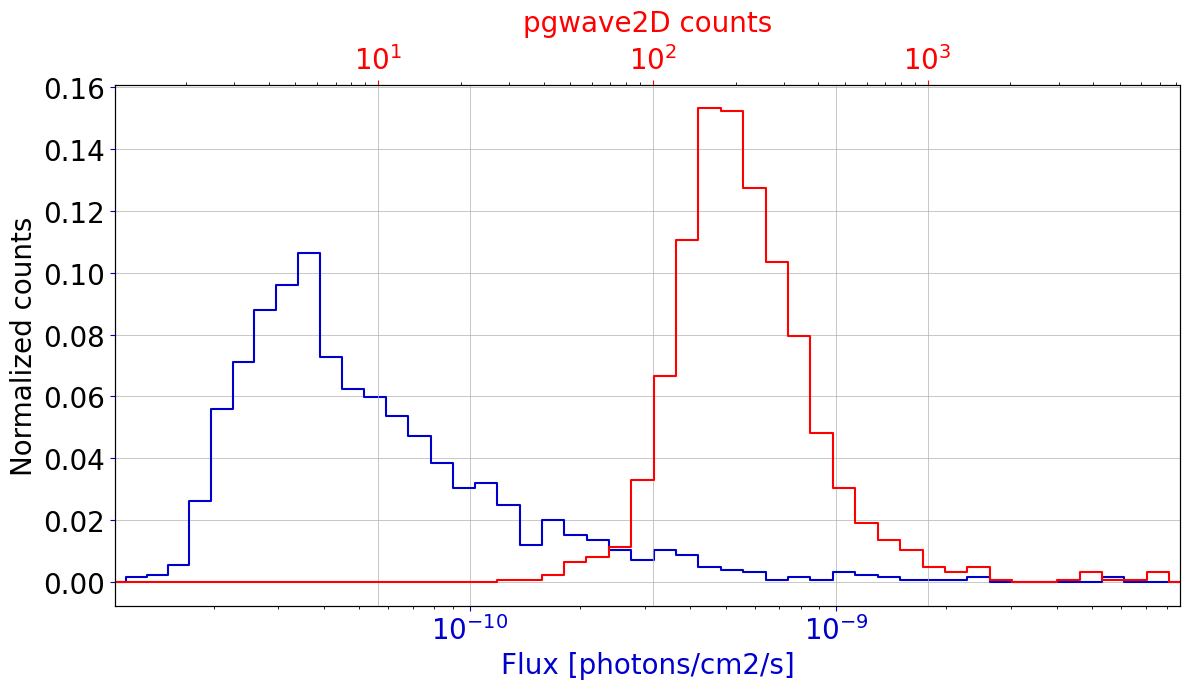

[2025-01-22 14:43:07,096] Done!


In [7]:
# ==========================================================================================
#                              HISTO 1D: COUNTS and FLUXES
# ==========================================================================================
# Compute the distribution of fluxes and pgwave2D counts for the matched sources
fluxbins = np.logspace(-11,-8,50)
histoFlux, binsFlux = truehisto1D(all_matchedRealFlux,bins=fluxbins)

countsbins = np.logspace(0,4,50)
histoCounts, binsCounts = truehisto1D(all_matchedPgCounts,bins=countsbins)

# Normalize the histograms
histoFlux = histoFlux / np.sum(histoFlux)
histoCounts = histoCounts / np.sum(histoCounts)

# Show the histograms in a single plot
logging.info(f"Plotting the histos1D (flux and pgwave2D counts distibutions)...")
figname = os.path.join(imgdir,'05_optConfigFinder',f'pgwave_bestpars_{config}_histos1D.pdf')

color1 = 'mediumblue'
color2 = 'red'

fig,ax1 = plt.subplots(figsize = dimfig)
histoplotter1D(ax1,binsFlux,histoFlux,'Flux [photons/cm2/s]','Normalized counts','Data','best',textfont,
               hcolor = color1)
ax1.set_xlabel('Flux [photons/cm2/s]',color=color1,fontsize=textfont)
ax1.set_xticklabels(ax1.get_xticklabels(),color=color1)
ax1.tick_params(color=color1)
ax1.get_legend().remove()
ax1.set_xscale('log')

ax2 = ax1.twiny()
histoplotter1D(ax2,binsCounts,histoCounts,'Pg counts','Counts','Data','best',textfont,hcolor=color2)
ax2.set_xlabel('pgwave2D counts',color=color2,fontsize=textfont,labelpad=10)
ax2.set_xticklabels(ax2.get_xticklabels(),color=color2)
ax2.tick_params(color=color2)
ax2.get_legend().remove()
ax2.set_xscale('log')

fig.set_tight_layout('tight')
fig.savefig(figname)
#plt.close(fig)
plt.show()
logging.info("Done!")

[2025-01-22 14:43:14,026] Plotting the scatter plot (pgwave2D K-significance vs pgwave2D counts)...


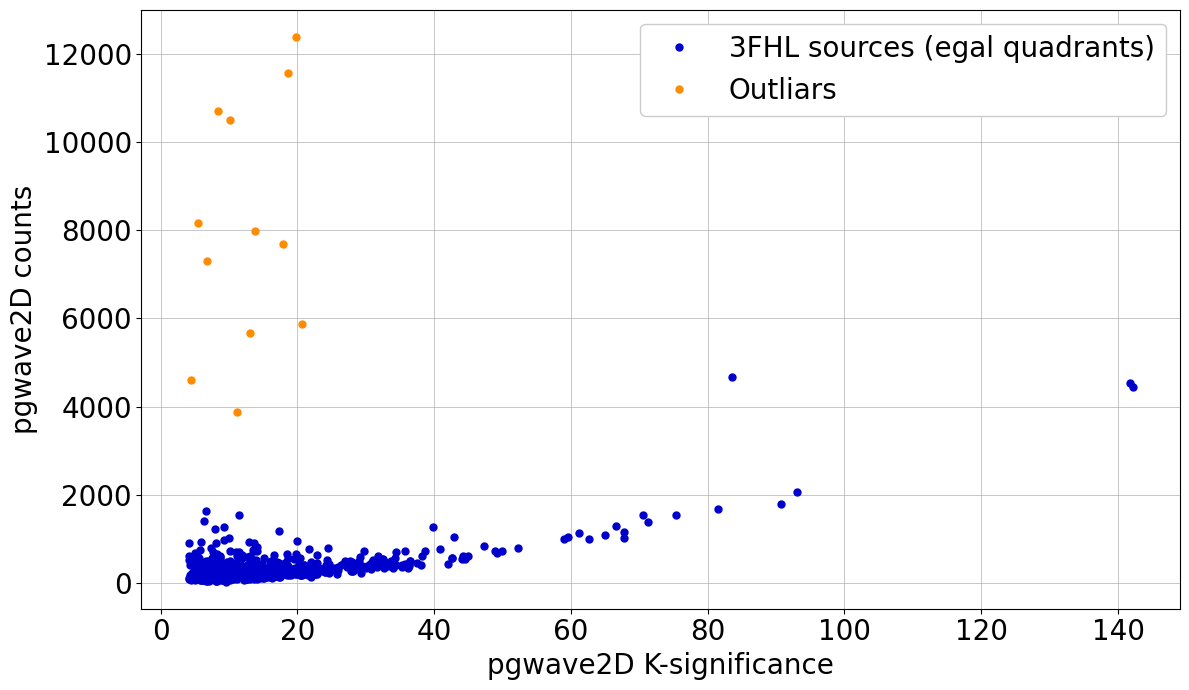

[2025-01-22 14:43:14,749] Done!


In [8]:
# ==========================================================================================
#                         SCATTERPLOT 1D: COUNTS vs K-SIGNIFICANCE
# ==========================================================================================
# Define the colors for the plotting
color_true = 'mediumblue'
color_outliars = 'darkorange'

# Plot the data
logging.info(f"Plotting the scatter plot (pgwave2D K-significance vs pgwave2D counts)...")
figname = os.path.join(imgdir,'05_optConfigFinder',f'pgwave_bestpars_{config}_scatter_countsVSk.pdf')

fig,ax = plt.subplots(figsize = dimfig)
ax.plot(all_matchedKsignif[cond_true],all_matchedPgCounts[cond_true],color=color_true,
        linestyle='', marker='.',markersize=10, label = f'3FHL sources ({config} quadrants)')
ax.plot(all_matchedKsignif[cond_outliars],all_matchedPgCounts[cond_outliars],color=color_outliars,
        linestyle='', marker='.',markersize=10, label = f'Outliars')
ax.legend(loc = 'upper right', fontsize = textfont, framealpha = 1)
ax.set_xlabel(f"pgwave2D K-significance",fontsize = textfont)
ax.set_ylabel(f"pgwave2D counts",fontsize = textfont)
ax.grid(linewidth=0.5)
ax.tick_params(labelsize = textfont)
    
fig.set_tight_layout('tight')
fig.savefig(figname)
#plt.close(fig)
plt.show()
logging.info("Done!")

[2025-01-22 14:43:18,974] Plotting the scatter plot (SNR vs pgwave2D counts)...


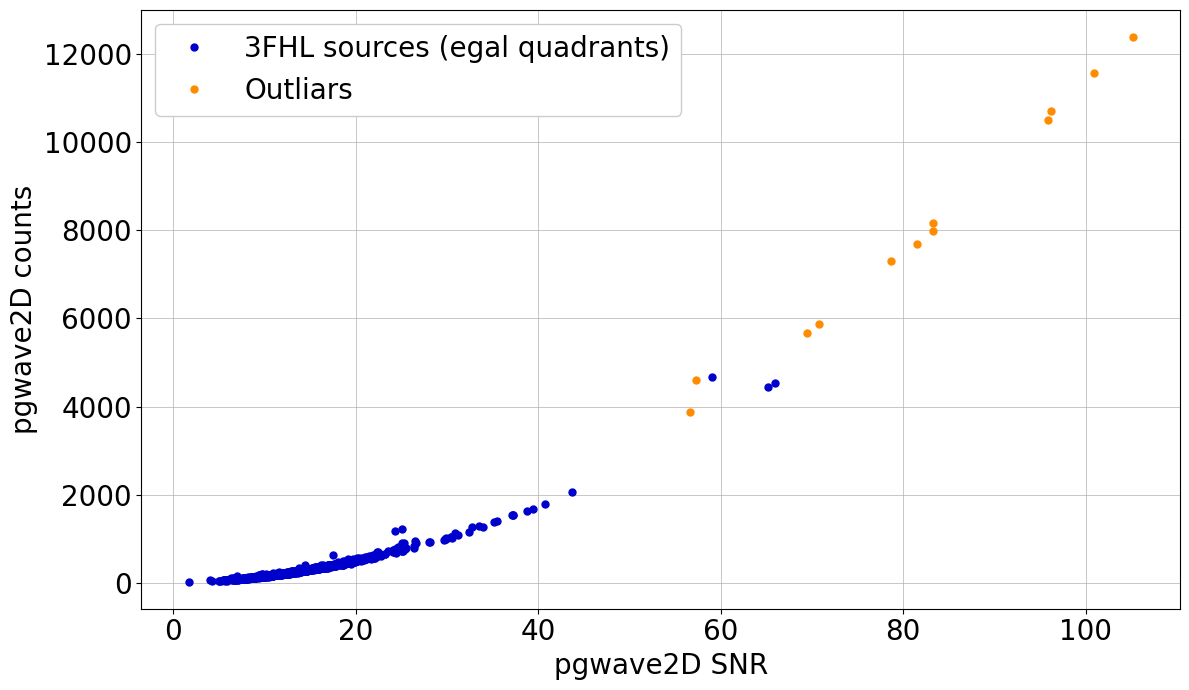

[2025-01-22 14:43:19,881] Done!


In [9]:
# ==========================================================================================
#                         SCATTERPLOT 1D: COUNTS vs SNR
# ==========================================================================================
# Plot the data
logging.info(f"Plotting the scatter plot (SNR vs pgwave2D counts)...")
figname = os.path.join(imgdir,'05_optConfigFinder',f'pgwave_bestpars_{config}_scatter_countsVSsnr.pdf')

fig,ax = plt.subplots(figsize = dimfig)
ax.plot(all_matchedSNR[cond_true],all_matchedPgCounts[cond_true],color=color_true,
        linestyle='', marker='.',markersize=10, label = f'3FHL sources ({config} quadrants)')
ax.plot(all_matchedSNR[cond_outliars],all_matchedPgCounts[cond_outliars],color=color_outliars,
        linestyle='', marker='.',markersize=10, label = f'Outliars')
ax.legend(loc = 'upper left', fontsize = textfont, framealpha = 1)
ax.set_xlabel(f"pgwave2D SNR",fontsize = textfont)
ax.set_ylabel(f"pgwave2D counts",fontsize = textfont)
ax.grid(linewidth=0.5)
ax.tick_params(labelsize = textfont)
    
fig.set_tight_layout('tight')
fig.savefig(figname)
#plt.close(fig)
plt.show()
logging.info("Done!")

[2025-01-22 14:43:22,574] Plotting the scatter plot (fluxes vs pgwave2D counts)...


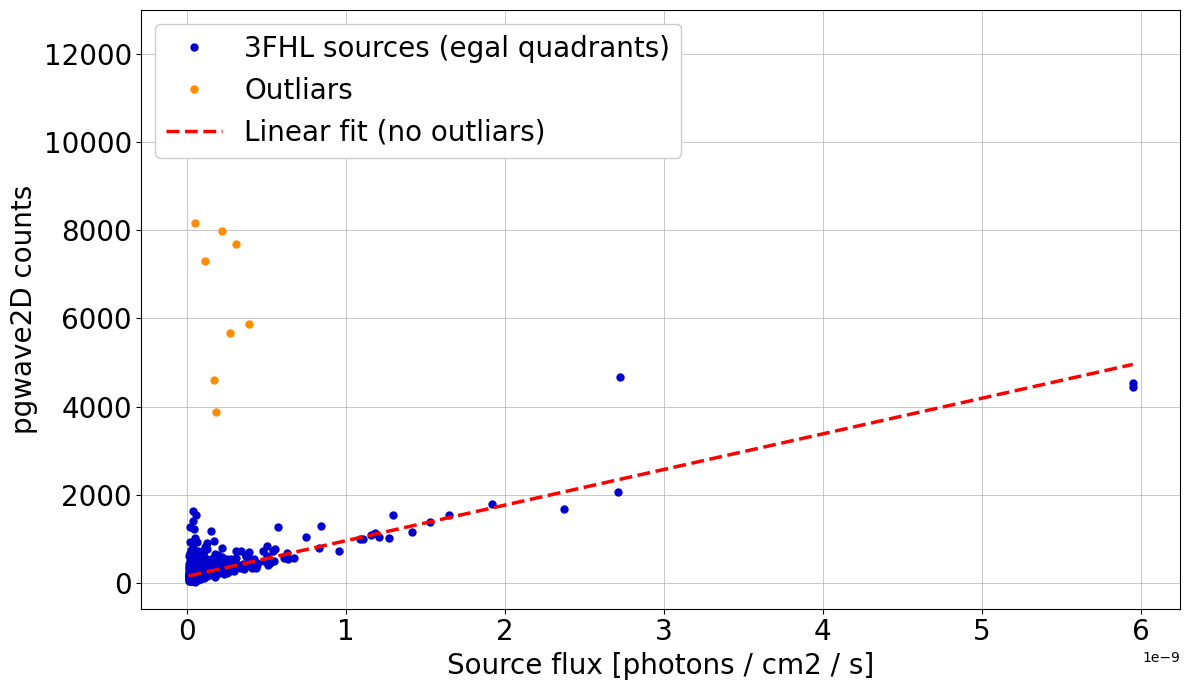

[2025-01-22 14:43:23,380] Done!


In [10]:
# ==========================================================================================
#                         SCATTERPLOT 1D: COUNTS vs FLUX
# ==========================================================================================
# Plot the data
logging.info(f"Plotting the scatter plot (fluxes vs pgwave2D counts)...")
figname = os.path.join(imgdir,'05_optConfigFinder',f'pgwave_bestpars_{config}_scatter_countsVSflux.pdf')

fig,ax = plt.subplots(figsize = dimfig)
ax.plot(all_matchedRealFlux[cond_true],all_matchedPgCounts[cond_true],color=color_true,
        linestyle='', marker='.',markersize=10, label = f'3FHL sources ({config} quadrants)')
ax.plot(all_matchedRealFlux[cond_outliars],all_matchedPgCounts[cond_outliars],color=color_outliars,
        linestyle='', marker='.',markersize=10, label = f'Outliars')
ax.plot(xth,yth,color='red',linestyle='--',linewidth=2.5,label=f"Linear fit (no outliars)")
ax.legend(loc = 'upper left', fontsize = textfont, framealpha = 1)
ax.set_xlabel(f"Source flux [photons / cm2 / s]",fontsize = textfont)
ax.set_ylabel(f"pgwave2D counts",fontsize = textfont)
ax.grid(linewidth=0.5)
ax.tick_params(labelsize = textfont)
    
fig.set_tight_layout('tight')
fig.savefig(figname)
#plt.close(fig)
plt.show()
logging.info("Done!")

[2025-01-22 14:43:26,499] Plotting the scatter plot (angular error vs pgwave2D counts)...


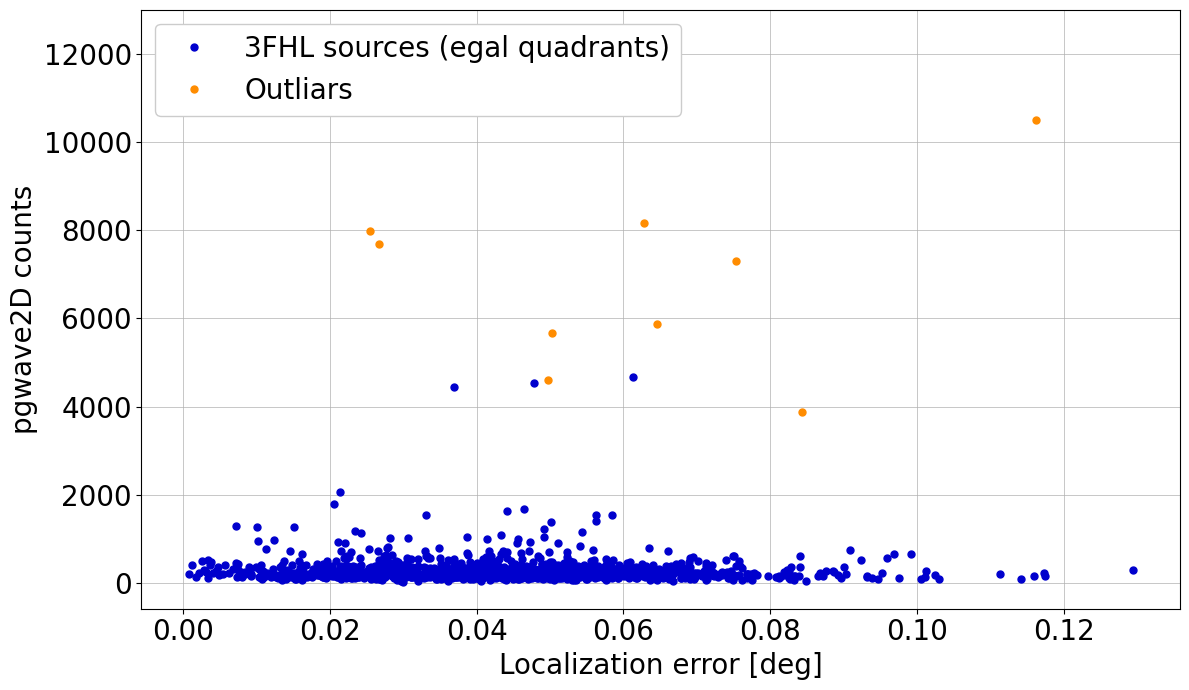

[2025-01-22 14:43:27,348] Done!


In [11]:
# ==========================================================================================
#                         SCATTERPLOT 1D: COUNTS vs ANGULAR ERROR
# ==========================================================================================
# Plot the data
logging.info(f"Plotting the scatter plot (angular error vs pgwave2D counts)...")
figname = os.path.join(imgdir,'05_optConfigFinder',f'pgwave_bestpars_{config}_scatter_countsVSangdist.pdf')

fig,ax = plt.subplots(figsize = dimfig)
ax.plot(all_matchedDistances[cond_true],all_matchedPgCounts[cond_true],color=color_true,
        linestyle='', marker='.',markersize=10, label = f'3FHL sources ({config} quadrants)')
ax.plot(all_matchedDistances[cond_outliars],all_matchedPgCounts[cond_outliars],color=color_outliars,
        linestyle='', marker='.',markersize=10, label = f'Outliars')
ax.legend(loc = 'upper left', fontsize = textfont, framealpha = 1)
ax.set_xlabel(f"Localization error [deg]",fontsize = textfont)
ax.set_ylabel(f"pgwave2D counts",fontsize = textfont)
#ax.set_ylim([0,3000])
ax.grid(linewidth=0.5)
ax.tick_params(labelsize = textfont)

fig.set_tight_layout('tight')
fig.savefig(figname)
#plt.close(fig)
plt.show()
logging.info("Done!")

[2025-01-22 16:24:03,147] Plotting the scatter plot (angular error vs pgwave2D counts)...


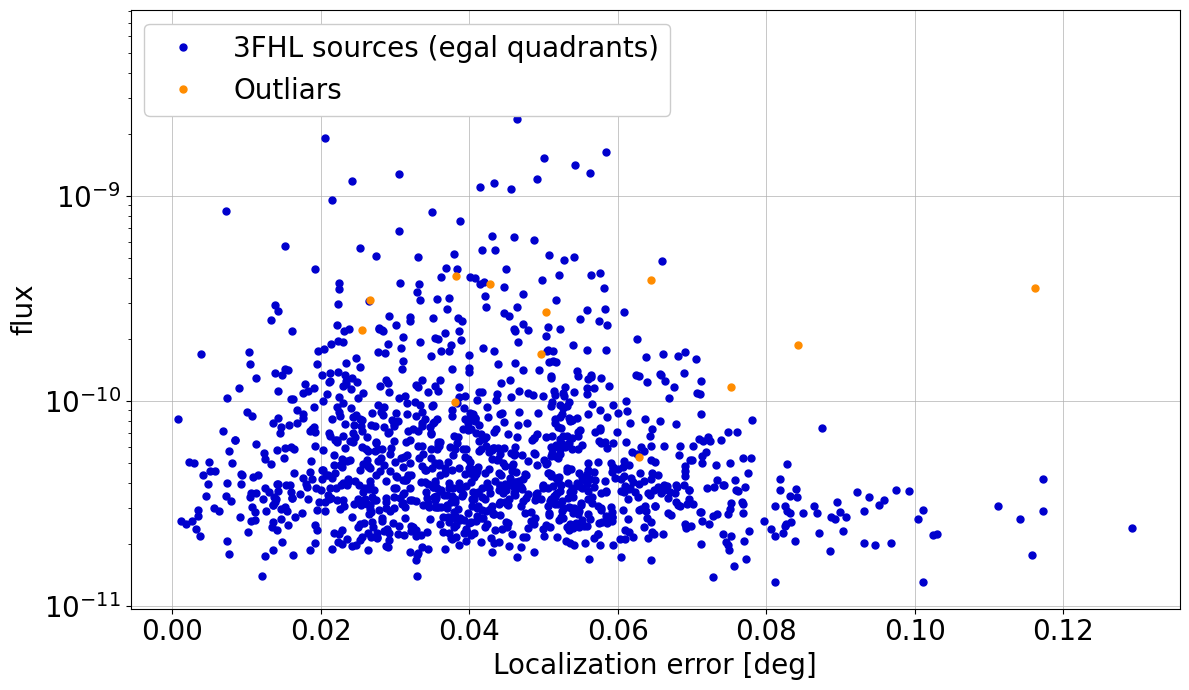

[2025-01-22 16:24:04,792] Done!


In [46]:
# ==========================================================================================
#                         SCATTERPLOT 1D: COUNTS vs ANGULAR ERROR
# ==========================================================================================
# Plot the data
logging.info(f"Plotting the scatter plot (angular error vs pgwave2D counts)...")
figname = os.path.join(imgdir,'05_optConfigFinder',f'pgwave_bestpars_{config}_scatter_countsVSangdist.pdf')

fig,ax = plt.subplots(figsize = dimfig)
ax.plot(all_matchedDistances[cond_true],all_matchedRealFlux[cond_true],color=color_true,
        linestyle='', marker='.',markersize=10, label = f'3FHL sources ({config} quadrants)')
ax.plot(all_matchedDistances[cond_outliars],all_matchedRealFlux[cond_outliars],color=color_outliars,
        linestyle='', marker='.',markersize=10, label = f'Outliars')
ax.legend(loc = 'upper left', fontsize = textfont, framealpha = 1)
ax.set_xlabel(f"Localization error [deg]",fontsize = textfont)
ax.set_ylabel(f"flux",fontsize = textfont)
#ax.set_ylim([0,3000])
ax.grid(linewidth=0.5)
ax.tick_params(labelsize = textfont)
ax.set_yscale('log')

fig.set_tight_layout('tight')
fig.savefig(figname)
#plt.close(fig)
plt.show()
logging.info("Done!")

[2025-01-22 14:43:30,399] Plotting the scatter plot (angular error vs pgwave2D counts)...


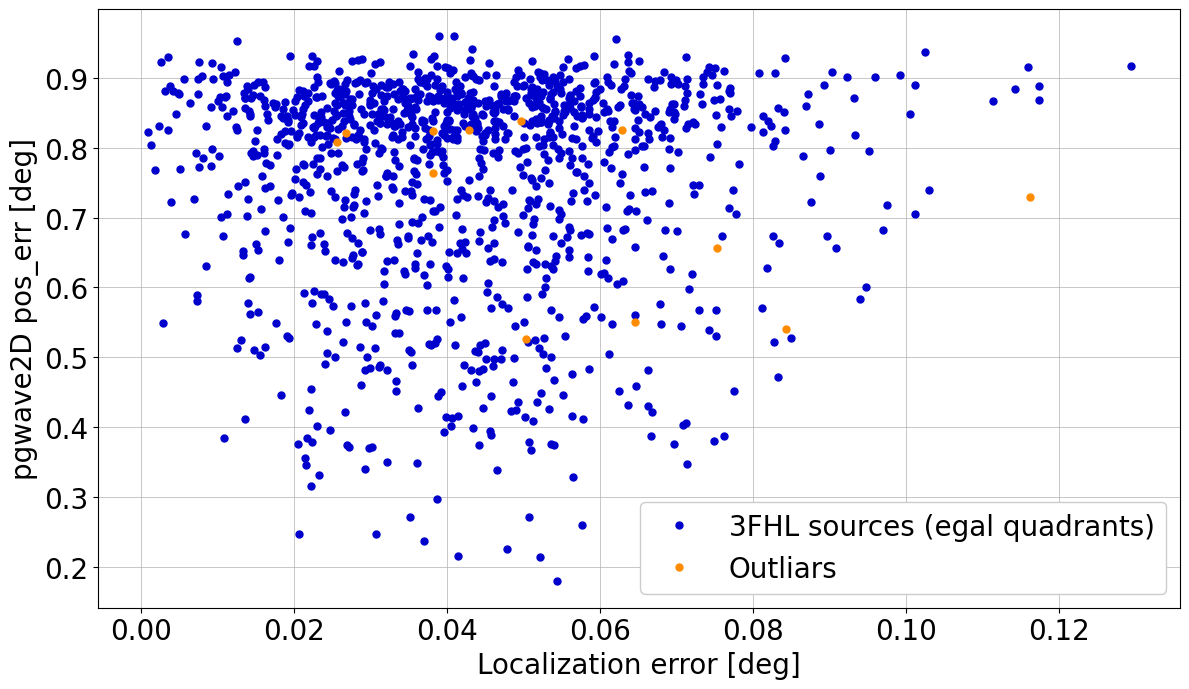

[2025-01-22 14:43:31,447] Done!


In [12]:
# ==========================================================================================
#                         SCATTERPLOT 1D: POS ERR vs ANGULAR ERROR
# ==========================================================================================
# Plot the data
logging.info(f"Plotting the scatter plot (angular error vs pgwave2D counts)...")
figname = os.path.join(imgdir,'05_optConfigFinder',f'pgwave_bestpars_{config}_scatter_poserrVSangdist.pdf')

fig,ax = plt.subplots(figsize = dimfig)
ax.plot(all_matchedDistances[cond_true],all_matchedPosErr[cond_true],color=color_true,
        linestyle='', marker='.',markersize=10, label = f'3FHL sources ({config} quadrants)')
ax.plot(all_matchedDistances[cond_outliars],all_matchedPosErr[cond_outliars],color=color_outliars,
        linestyle='', marker='.',markersize=10, label = f'Outliars')
ax.legend(loc = 'lower right', fontsize = textfont, framealpha = 1)
ax.set_xlabel(f"Localization error [deg]",fontsize = textfont)
ax.set_ylabel(f"pgwave2D pos_err [deg]",fontsize = textfont)
#ax.set_ylim([0,3000])
ax.grid(linewidth=0.5)
ax.tick_params(labelsize = textfont)

fig.set_tight_layout('tight')
fig.savefig(figname)
#plt.close(fig)
plt.show()
logging.info("Done!")

[2025-01-22 16:25:29,475] Plotting the histos1D (distance distibutions)...
/tmp/ipykernel_1773/915715515.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(),color=color1)
/tmp/ipykernel_1773/915715515.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(),color=color2)


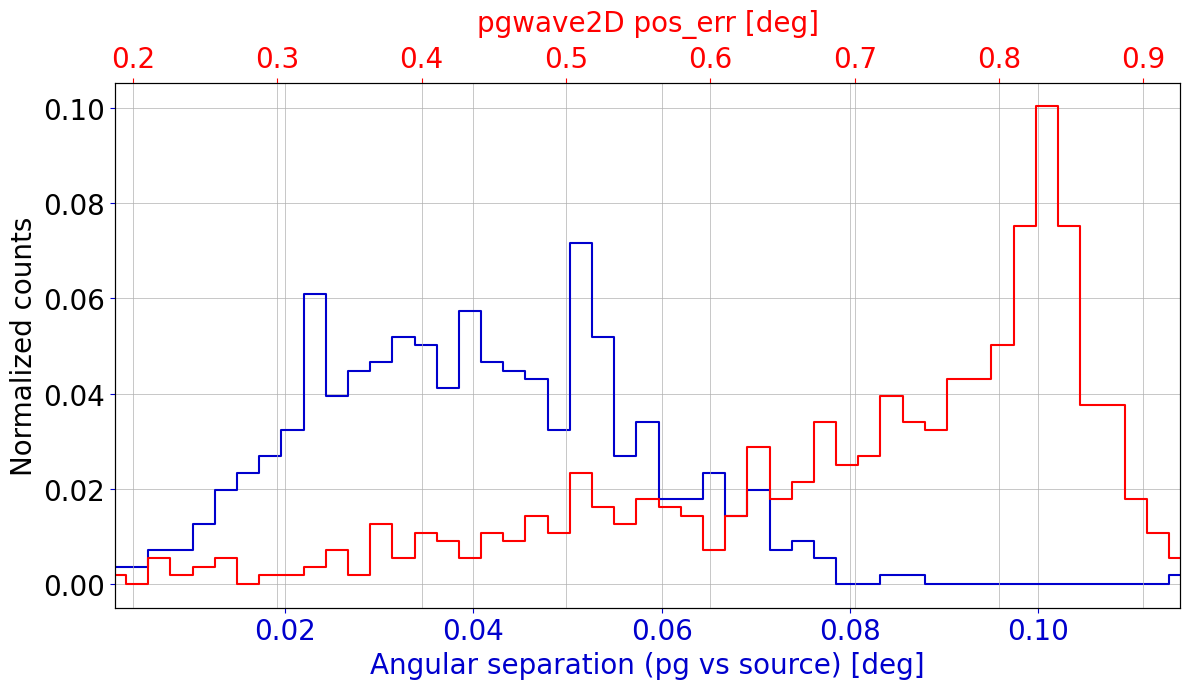

[2025-01-22 16:25:31,089] Done!


In [47]:
#all_matchedDistances.mean(),all_matchedPosErr.mean(),

# ==========================================================================================
#                              HISTO 1D: COUNTS and FLUXES
# ==========================================================================================
# Compute the distribution of localization errors
cond = (all_matchedRealFlux >= 5e-11)
histoDistances, binsDistances = truehisto1D(all_matchedDistances[cond],nbins=50)
histoPosErr, binsPosErr = truehisto1D(all_matchedPosErr[cond],nbins=50)

# Normalize the histograms
histoDistances = histoDistances / np.sum(histoDistances)
histoPosErr = histoPosErr / np.sum(histoPosErr)

# Show the histograms in a single plot
logging.info(f"Plotting the histos1D (distance distibutions)...")
figname = os.path.join(imgdir,'05_optConfigFinder',f'pgwave_bestpars_{config}_histos1D_dist.pdf')

color1 = 'mediumblue'
color2 = 'red'

fig,ax1 = plt.subplots(figsize = dimfig)
histoplotter1D(ax1,binsDistances,histoDistances,'Angular separation (pg vs source) [deg]',
               'Normalized counts','Data','best',textfont, hcolor = color1)
ax1.set_xlabel('Angular separation (pg vs source) [deg]',color=color1,fontsize=textfont)
ax1.set_xticklabels(ax1.get_xticklabels(),color=color1)
ax1.tick_params(color=color1)
ax1.get_legend().remove()
#ax1.set_xscale('log')

ax2 = ax1.twiny()
histoplotter1D(ax2,binsPosErr,histoPosErr,'pgwave2D pos_err [deg]','Counts','Data','best',textfont,hcolor=color2)
ax2.set_xlabel('pgwave2D pos_err [deg]',color=color2,fontsize=textfont,labelpad=10)
ax2.set_xticklabels(ax2.get_xticklabels(),color=color2)
ax2.tick_params(color=color2)
ax2.get_legend().remove()
#ax2.set_xscale('log')

fig.set_tight_layout('tight')
fig.savefig(figname)
#plt.close(fig)
plt.show()
logging.info("Done!")

[2025-01-22 16:10:00,002] Plotting the scatter plot (angular error vs pgwave2D counts)...


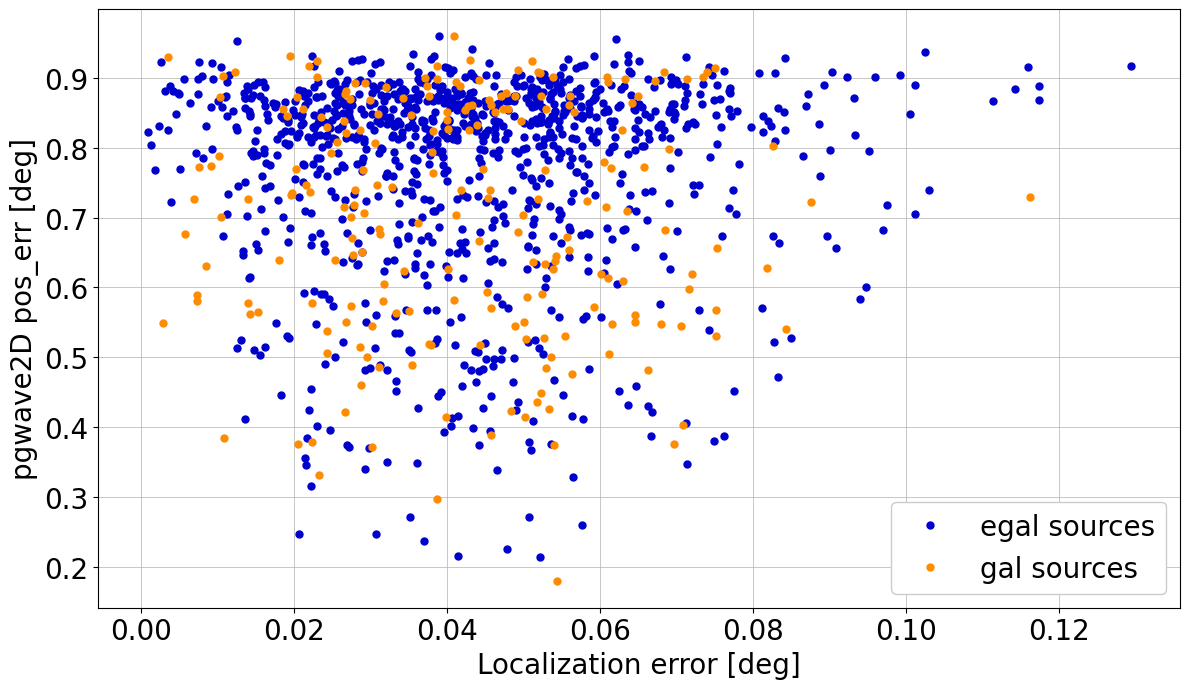

[2025-01-22 16:10:00,898] Done!


In [34]:
# ==========================================================================================
#                         SCATTERPLOT 1D: POS ERR vs ANGULAR ERROR
# ==========================================================================================
# Plot the data
cond_egal = (np.abs(all_matchedGLat) > 20)
cond_gal = (cond_egal == False)

logging.info(f"Plotting the scatter plot (angular error vs pgwave2D counts)...")
figname = os.path.join(imgdir,'05_optConfigFinder',f'pgwave_bestpars_{config}_scatter_poserrVSangdist.pdf')

fig,ax = plt.subplots(figsize = dimfig)
ax.plot(all_matchedDistances[cond_egal],all_matchedPosErr[cond_egal],color=color_true,
        linestyle='', marker='.',markersize=10, label = f'egal sources')
ax.plot(all_matchedDistances[cond_gal],all_matchedPosErr[cond_gal],color=color_outliars,
        linestyle='', marker='.',markersize=10, label = f'gal sources')
ax.legend(loc = 'lower right', fontsize = textfont, framealpha = 1)
ax.set_xlabel(f"Localization error [deg]",fontsize = textfont)
ax.set_ylabel(f"pgwave2D pos_err [deg]",fontsize = textfont)
#ax.set_ylim([0,3000])
ax.grid(linewidth=0.5)
ax.tick_params(labelsize = textfont)

fig.set_tight_layout('tight')
fig.savefig(figname)
#plt.close(fig)
plt.show()
logging.info("Done!")

In [13]:
from MyFunctions import histoproj, truehisto2D, histoplotter2D, wmean

[2025-01-22 16:04:42,088] Plotting the scatter plot (pgwave2D pos_err / angdist vs angdist)


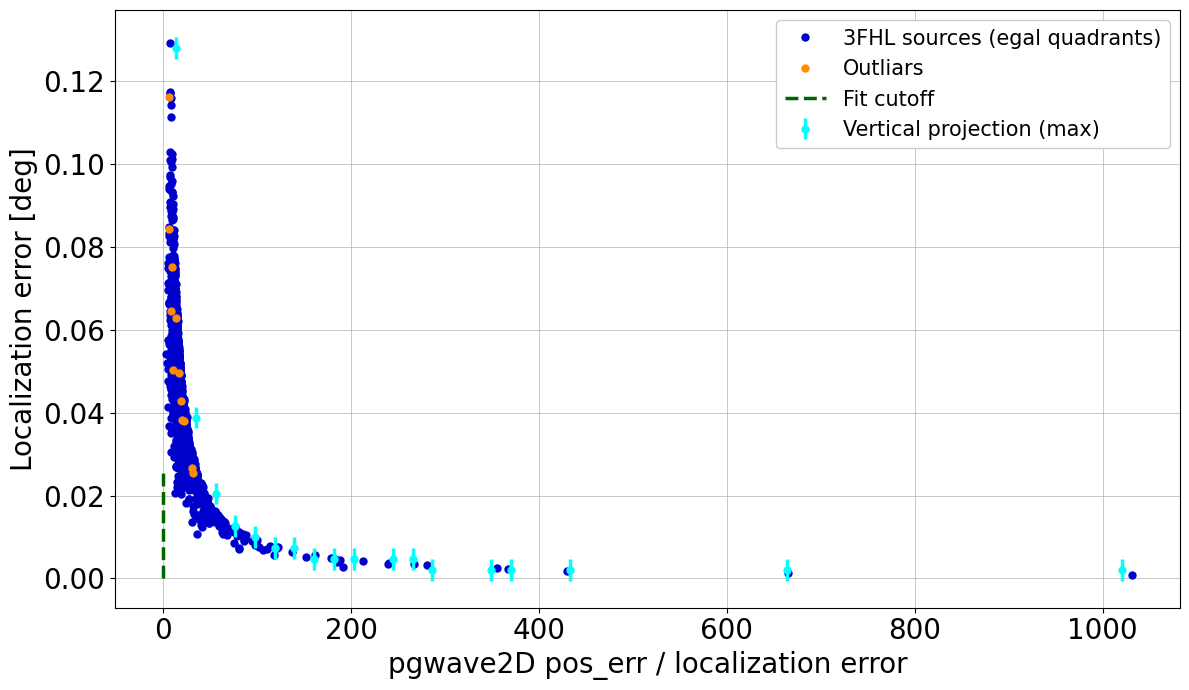

[2025-01-22 16:04:42,958] Done!


In [28]:
# ==========================================================================================
#                         SCATTERPLOT 1D: POS ERR vs ANGULAR ERROR
# ==========================================================================================
# Perform a linear calibration on the error position
all_matchedDistToPosErr = all_matchedPosErr / all_matchedDistances
#result_pos, xth_pos, yth_pos = fitter_linear(all_matchedDistToPosErr[cond_true],all_matchedDistances[cond_true],
                                            #fitcut_up = 0.05)

# Format the output
'''
m_pos,q_pos = result_pos.params['m'].value,result_pos.params['q'].value
m_pos_err, q_pos_err = result_pos.params['m'].stderr,result_pos.params['q'].stderr
logging.info(f"Let 'angdist' be the separation between true source position and pgwave2D localization")
logging.info(f"Fitting: angdist = m*(pgwave2D pos_err / angdist)")
logging.info(f"Fit parameters:")
logging.info(f"\t m = {m_pos:.2e} +/- {m_pos_err:.2e} deg")
logging.info(f"\t q = {q_pos:.2f} +/- {q_pos_err:.2f} deg")
logging.info(f"")
'''

# ==========================================================================================
# Add a sort of vertical projection of the dataset
nbins = 50
histo2D, binsX, binsY = truehisto2D(all_matchedDistToPosErr[cond_true],all_matchedDistances[cond_true], 
                                    nbinsX=nbins, nbinsY=nbins, ifstepX=False, ifstepY=False)
truex, histosum, histosum_err = histoproj(histo2D, binsX, binsY, axis='x', projtype='max', 
                                          selferr=0.01, errtype='bootstrap')
cutcond = (histosum > 0)
truex = truex[cutcond]
histosum = histosum[cutcond]
histosum_err = histosum_err[cutcond]

# Attempt another fit on the projection
xth_cut =  0.125
yth_cut = 0.15
result_pos, xth_pos, yth_pos = fitter_linear(truex,histosum,histosum_err)#,fitcut_up = xth_cut)
#xth_pos, yth_pos = xth_pos[xth_pos <= xth_cut], yth_pos[xth_pos <= xth_cut]
#xth_pos, yth_pos = xth_pos[yth_pos <= yth_cut], yth_pos[yth_pos <= yth_cut]


# Do the plot
logging.info(f"Plotting the scatter plot (pgwave2D pos_err / angdist vs angdist)")
figname = os.path.join(imgdir,'05_optConfigFinder',f'pgwave_bestpars_{config}_scatter_angdistVSposerrnorma.pdf')

fig,ax = plt.subplots(figsize = dimfig)
ax.plot(all_matchedDistToPosErr[cond_true],all_matchedDistances[cond_true],
        color=color_true, linestyle='', marker='.',markersize=10, label = f'3FHL sources ({config} quadrants)')
ax.plot(all_matchedDistToPosErr[cond_outliars],all_matchedDistances[cond_outliars],
        color=color_outliars, linestyle='', marker='.',markersize=10, label = f'Outliars')
#ax.plot(xth_pos,yth_pos,color='red',linestyle='--',linewidth=2.5,label=f"Linear fit (no outliars)")
ax.plot([xth_cut,xth_cut],[0,np.max(yth_pos)],color='darkgreen',linestyle='--',linewidth=2.5,
        label=f"Fit cutoff")
ax.errorbar(truex, histosum, histosum_err, color='cyan',linestyle='',linewidth=2.5, label=f"Vertical projection (max)",
            marker = '.', markersize = 10, capsize = None)
ax.legend(loc = 'upper right', fontsize = 0.75*textfont, framealpha = 1)
ax.set_xlabel(f"pgwave2D pos_err / localization error",fontsize = textfont)
ax.set_ylabel(f"Localization error [deg]",fontsize = textfont)
ax.grid(linewidth=0.5)
ax.tick_params(labelsize = textfont)

fig.set_tight_layout('tight')
fig.savefig(figname)
#plt.close(fig)
plt.show()
logging.info("Done!")

In [17]:
# ==========================================================================================
#                         SCATTERPLOT 1D: POS ERR vs ANGULAR ERROR
# ==========================================================================================
# Saving the calibration coefficients
outfilename = os.path.join(tempdir, pgwave_simdir, 'pgwave2D_calcoeffs.npz')
logging.info(f"Saving the outputs in:")
logging.info(outfilename)
np.savez_compressed(outfilename, m = m,
                                 q = q,
                                 m_err = m_err,
                                 q_err = q_err,
                                 m_pos = m_pos,
                                 q_pos = q_pos,
                                 m_pos_err = m_pos_err,
                                 q_pos_err = q_pos_err)

[2025-01-22 15:44:29,224] Saving the outputs in:
[2025-01-22 15:44:29,228] /home/pmgunix/pmg-home/FermiLAT/Tempfiles/04_4FHL/05_simPgwaveOut/pgwave2D_calcoeffs.npz
